# Librerias

In [114]:

import pandas as pd
import os
import pmdarima
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.stattools import adfuller,kpss
from arch.unitroot import PhillipsPerron as PP,DFGLS

# Modelizacion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


In [115]:
# Cargamos los datos
datos = pd.read_csv("DatosCreditosPersonales.csv")


In [116]:

del (datos["Unnamed: 0"])
# Pasamos la fecha a formato fecha
datos["Month-Year"] = pd.to_datetime(datos["Month-Year"], format="%b-%y")

# Pasamos la fecha al indice
datos.index = datos["Month-Year"]
del (datos["Month-Year"])


In [117]:
datos.head()

,Creditos_Personales
Month-Year,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


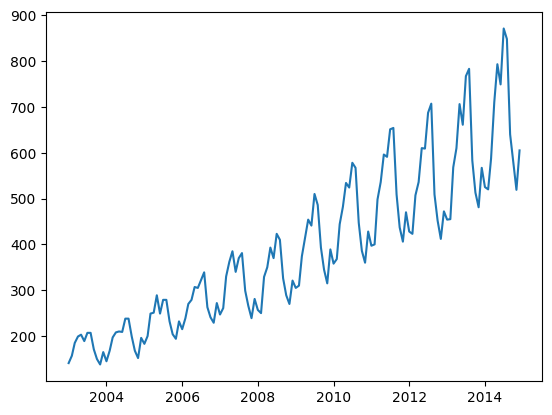

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(datos)

## Procedemos a calcular el numero de diferencias


In [119]:
# Respecto a la observacion anterior
pmdarima.arima.ndiffs(datos)

1

In [120]:
# Estacionalmente con estacionalidad anual.
pmdarima.arima.nsdiffs(datos, m = 12)

1

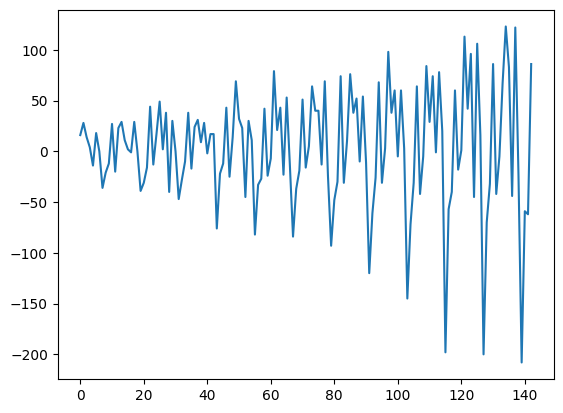

In [121]:
datosdiff = pmdarima.utils.diff(datos,lag = 1, differences= 1)
# Graficamos los datos diferenciados.
plt.plot(datosdiff)


# Se soluciona el problema de la media (se vuelve mas constante)
# Pero no el de la varianza, aumenta con el tiempo.

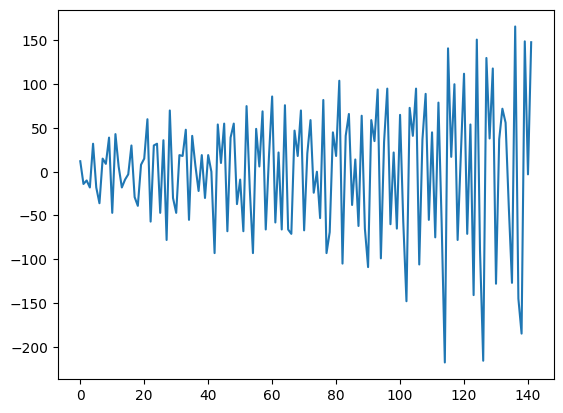

In [122]:

# Determinamos si hay que volver a diferenciarlo
pmdarima.arima.ndiffs(datosdiff)

# Indica que no pero lo comprobamos
datosdiff2 = pmdarima.utils.diff(datosdiff,lag = 1, differences= 1)

# Graficamos
plt.plot(datosdiff2)


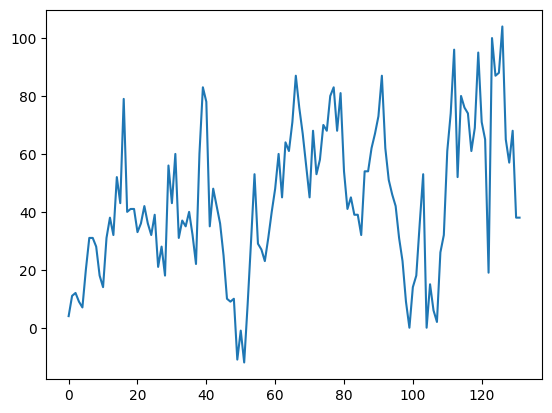

In [123]:

# Vemos que el problema no se soluciona
# Pasamos a probar la via estacional.
datosdiff_Est = pmdarima.utils.diff(datos,lag = 12, differences= 1)
# Graficamos.
plt.plot(datosdiff_Est)

In [124]:
pmdarima.arima.ndiffs(datosdiff_Est)

1

In [125]:
pmdarima.arima.nsdiffs(datosdiff_Est, m = 12)

0

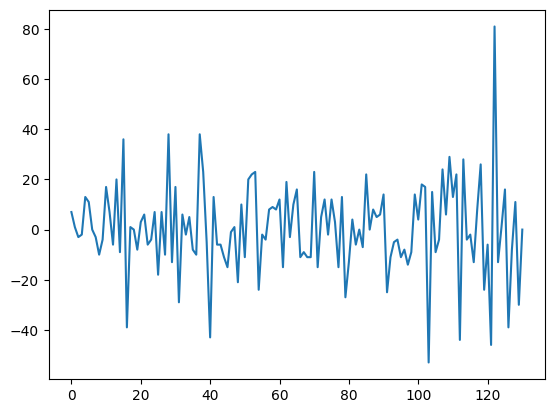

In [126]:
datosdiff_Est2 = pmdarima.utils.diff(datosdiff_Est,lag = 1, differences= 1)
plt.plot(datosdiff_Est2)
# Parece que mejora el problema de la varianza pero se aprecian 3 zonas.
# Probamos tomando logaritmos.

## Trasformamos a log

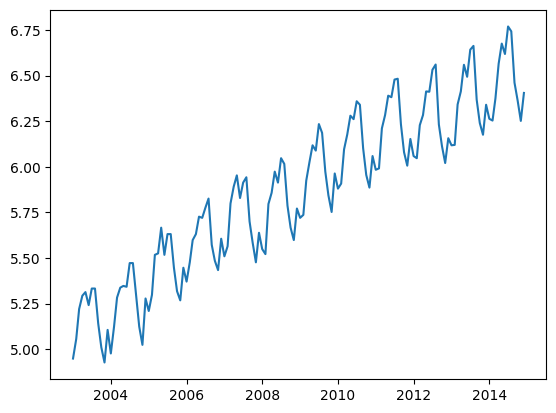

In [127]:
datos["Creditos_Personales"] = datos["Creditos_Personales"].astype(float)
Log_Datos = pd.DataFrame(np.log(datos["Creditos_Personales"]))

# Graficamos.
plt.plot(Log_Datos)

In [19]:
pmdarima.arima.ndiffs(Log_Datos)

1

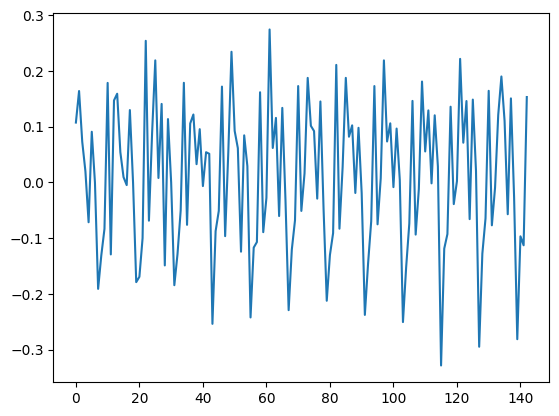

In [63]:
Log_Datos_Dif = pd.DataFrame(pmdarima.utils.diff(Log_Datos,lag = 1, differences= 1))

# Graficamos
plt.plot(Log_Datos_Dif)

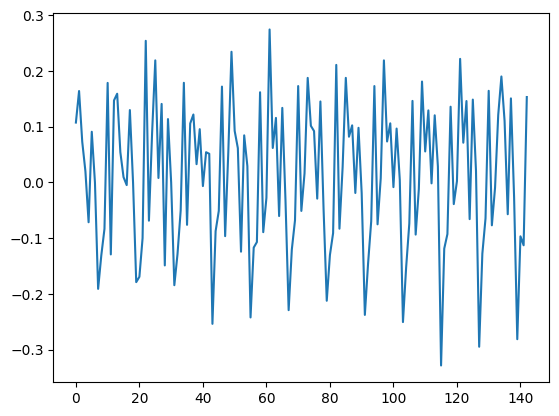

In [64]:
Log_Datos_Dif2 = pd.DataFrame(pmdarima.utils.diff(Log_Datos,lag = 12, differences= 1))
Log_Datos_Dif3 = pd.DataFrame(pmdarima.utils.diff(Log_Datos_Dif2,lag = 1, differences= 1))

# Graficamos
plt.plot(Log_Datos_Dif3)

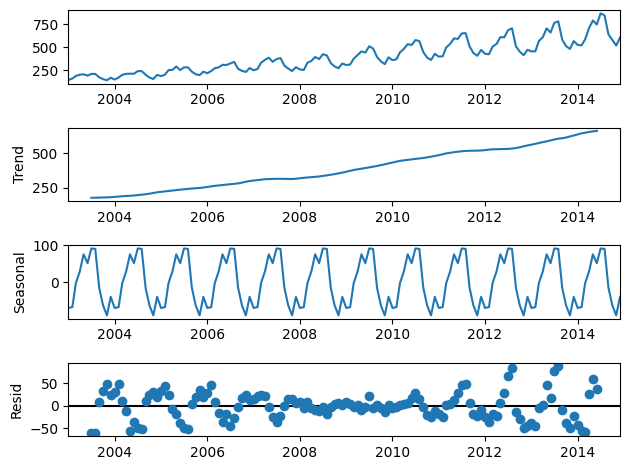

In [28]:
SerieDescompuesta = seasonal_decompose(datos, model='additive')
SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False);

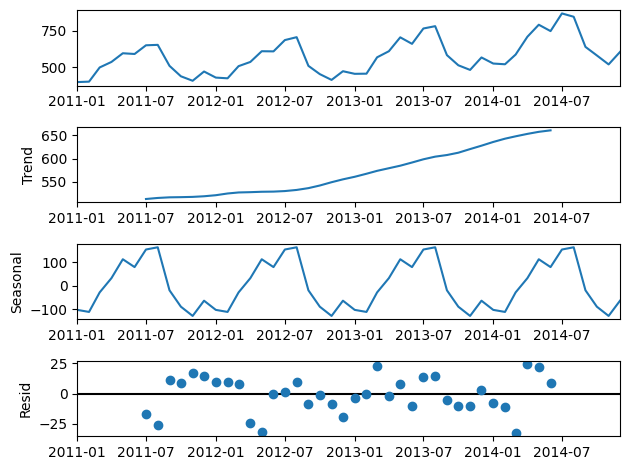

In [27]:
datos2 = datos.iloc[96:144,]
SerieDescompuesta2 = seasonal_decompose(datos2, model='additive')
SerieDescompuesta2.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False);

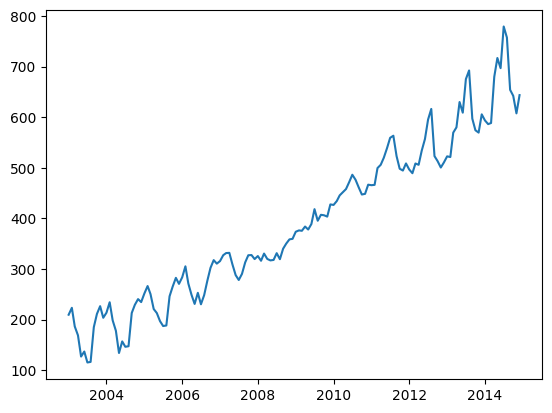

In [29]:
# Calculamos la Serie sin la componente estacional
SerieNoEstacional = datos["Creditos_Personales"] - SerieDescompuesta.seasonal

# La graficamos.
plt.plot(SerieNoEstacional)


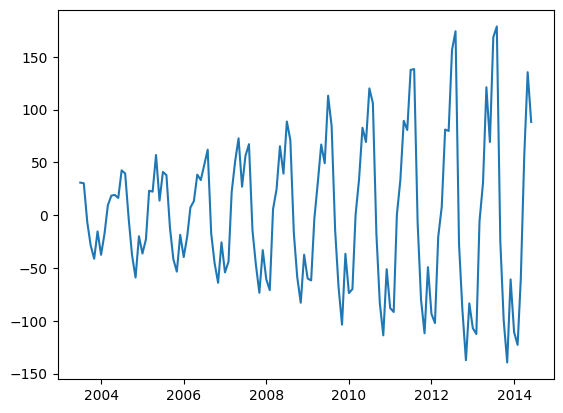

In [30]:
# Calculamos la serie sin ctendencia
SerieSinTendencia = datos["Creditos_Personales"] - SerieDescompuesta.trend

Residuos = datos["Creditos_Personales"] - SerieDescompuesta.seasonal - SerieDescompuesta.trend
# La graficamos.
plt.plot(SerieSinTendencia)


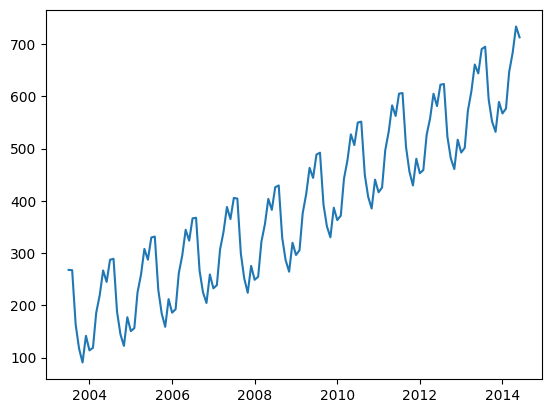

In [31]:

# Eliminamos la componente aleatoria.
SerieSinResiduos = datos["Creditos_Personales"] - SerieDescompuesta.resid

# La graficamos.
plt.plot(SerieSinResiduos)



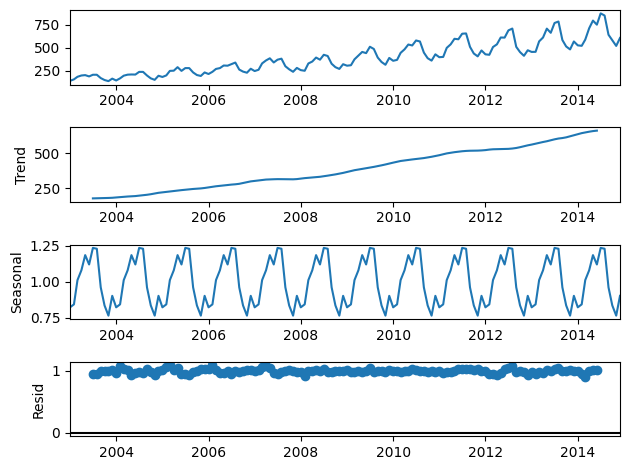

In [33]:
# La decomponemos de forma multiplicativa
# De manera aditiva
SerieDescompuestaMult = seasonal_decompose(datos, model='multiplicative')

# La graficamos.
SerieDescompuestaMult.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False);

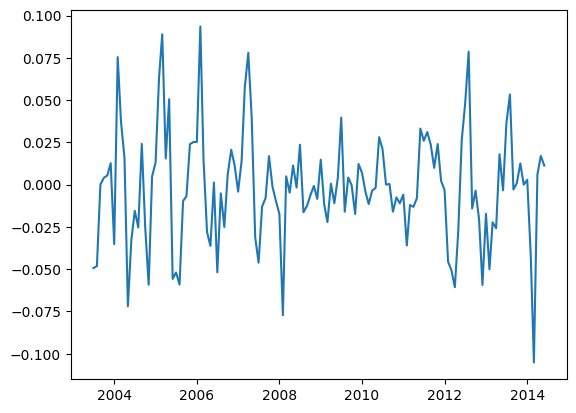

In [36]:
plt.plot(SerieDescompuestaMult.resid-1)

## Suavizado


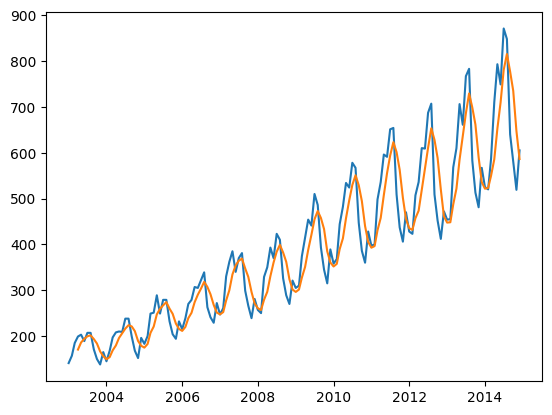

In [41]:
# Suavizado basado en medias moviles
datos['mov_avg'] = datos['Creditos_Personales'].rolling(4).mean()
# Graficamos esta nueva serie
plt.plot(datos)
del (datos['mov_avg'])

## Exponential Smoothing holtwinters

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


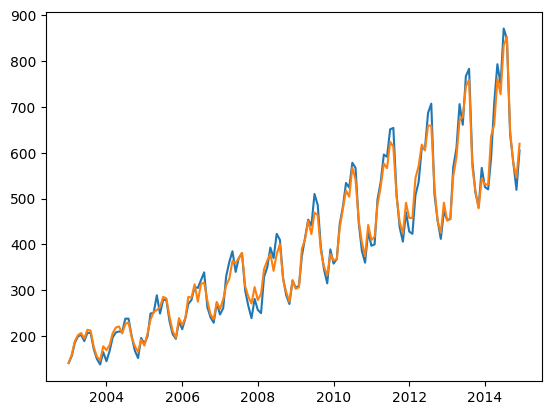

In [47]:

model = HWES(datos, seasonal_periods=12, trend='add', seasonal='add').fit()

# Graficamos el suavizado expoencial
datos["HWES"] = model.fittedvalues
plt.plot(datos)
# La eliminamos 
del (datos["HWES"])

# Estariedad de la serie

## Estariedad de la serie sin diferencias

### ADF
H0: No estacionario (raiz unitaria)

In [50]:
ADF = adfuller(datos["Creditos_Personales"])

# Mostramos los resultados
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: 1.108825
p-value: 0.995291


No tenemos suficiente evidencia estadistica para rechazar H0 -> Serie no estacionaria

### KPSS
H0: Serie Estacionaria


In [52]:
KPSS = kpss(datos["Creditos_Personales"])

# Mostramos los valores
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 1.634056
p-value: 0.010000


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Rechazamos H0 -> Serie No estacionaria


### PP
H0: Serie  NO Estacionaria


In [59]:
pp_results = PP(datos["Creditos_Personales"])

# Mostramos los valores
pp_results

Test Statistic,-1.656
P-value,0.454
Lags,14


No tenemos suficiente evidencia estadistica para rechazar H0 -> Serie no estacionaria


### ERS

H0: Serie  NO Estacionaria

In [61]:

ERS = DFGLS(datos["Creditos_Personales"])

# Mostramos los valores
ERS

Test Statistic,1.205
P-value,0.946
Lags,13


No tenemos suficiente evidencia estadistica para rechazar H0 -> Serie no estacionaria

## Estariedad de la serie con diferencias

In [66]:
Log_Datos_Dif

,0
0,0.107486
1,0.164110
2,0.072949
3,0.019901
4,-0.071459
...,...
138,-0.026761
139,-0.281412
140,-0.096717
141,-0.112847


### ADF
H0: No estacionario (raiz unitaria)

In [67]:
ADF = adfuller(Log_Datos_Dif[0])

# Mostramos los resultados
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -2.680467
p-value: 0.077480


- No tenemos suficiente evidencia estadistica para rechazar H0 al 95% -> Serie no estacionaria

- Rechazamos H0 al 90%, no al 95%.


### KPSS
H0: Serie Estacionaria


In [69]:
KPSS = kpss(Log_Datos_Dif[0])

# Mostramos los valores
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 0.024525
p-value: 0.100000


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Rechazamos H0 -> Serie No estacionaria


### ERS

H0: Serie  NO Estacionaria

In [73]:

ERS = DFGLS(Log_Datos_Dif)

# Mostramos los valores
ERS

Test Statistic,-0.208
P-value,0.618
Lags,14


No rechazamos H0

Pero parece que tiene mejor pinta que los pasados

# Modelización

## Correlograma


Estamos viendo las relaciones entre las observaciones $ y_t  \to  y_{t-1}, y_{t-2}, \dots $ 
Si existe alguna relación periodica o no en los correlogramas. Pero cuidado porque a veces las relaciones que se ven no tienen sentido de negocio. Por ejemplo en el parcial se esta viendo una relacion cada 6 meses pero no tiene sentido de negocio,

Para le modelo queremos predecir los datos, por eso metemos el log sin la diff

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


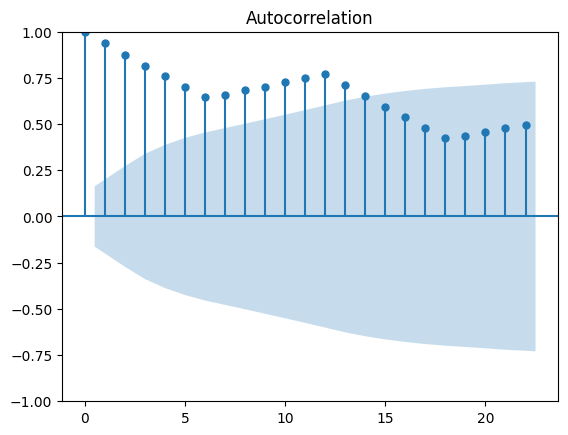

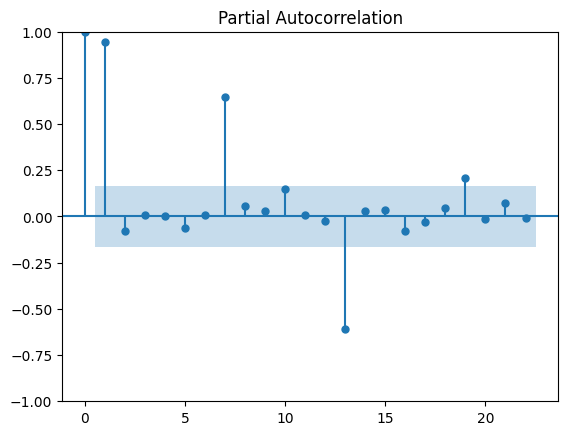

In [128]:
plot_acf(Log_Datos);
plot_pacf(Log_Datos);

## Dividimos los datos en train y test
Para le modelo queremos predecir los datos, por eso metemos el log sin la diff

In [161]:
train = Log_Datos.loc[:"2010-12-01 00:00:00"]
test = Log_Datos["2011-01-01 00:00:00":]
train.size

96

## Entrenamos 

In [174]:
model = sm.tsa.statespace.SARIMAX(train.iloc[:,0], order=(1,1,1), seasonal_order=(1,0,1,12),enforce_stationarity=False,mle_regression=False)

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [175]:
ArimaModel = model.fit()
ArimaModel.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.89881D-01    |proj g|=  5.82011D+00

At iterate    5    f= -1.46991D+00    |proj g|=  6.97666D-01

At iterate   10    f= -1.49965D+00    |proj g|=  1.37004D-01

At iterate   15    f= -1.50149D+00    |proj g|=  4.00303D-01

At iterate   20    f= -1.50159D+00    |proj g|=  1.35889D-02

At iterate   25    f= -1.50588D+00    |proj g|=  1.16349D-01

At iterate   30    f= -1.50993D+00    |proj g|=  1.08542D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Creditos_Personales   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 144.954
Date:                            Fri, 03 Feb 2023   AIC                           -279.909
Time:                                    19:10:24   BIC                           -267.936
Sample:                                01-01-2003   HQIC                          -275.105
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2252      0.259      0.869      0.385      -0.283       0.733
ma.L1         -0.6114      0.231     -2.642      0.008      -1.065      -0.158
ar.S.L12       1.0074      0.021     47.605      0.000       0.966       1.049
ma.S.L12      -0.6350      0.152     -4.190      0.000      -0.932      -0.338
sigma2         0.0015      0.000      5.920      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.84   Prob(JB):                         0.25
Heteroskedasticity (H):               0.31   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

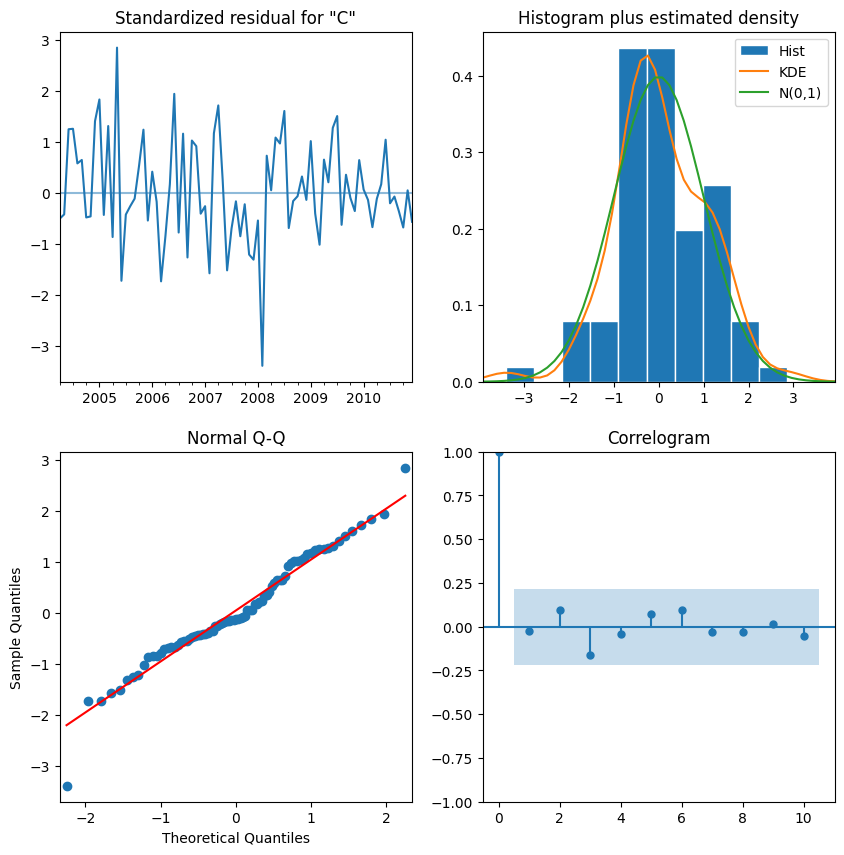

In [169]:
fig =plt.figure(figsize=(10, 10))
ArimaModel.plot_diagnostics(fig=fig);

In [132]:
test["Predicciones"] = ArimaModel.forecast(len(test))

/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/2170066692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel.forecast(len(test))


/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/3539434704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/3539434704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"]  = np.exp(test["Predicciones"])


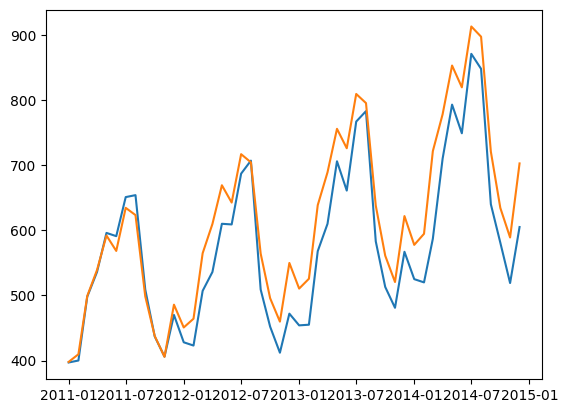

In [133]:
test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
test["Predicciones"]  = np.exp(test["Predicciones"])
plt.plot(test)

## AUTOARIMA

/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:14: SettingWithCopyWarning: 
A value is t

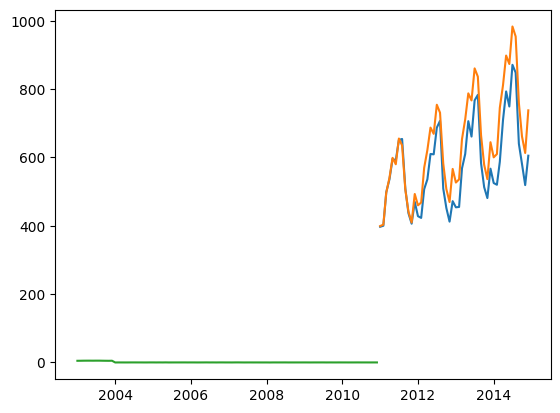

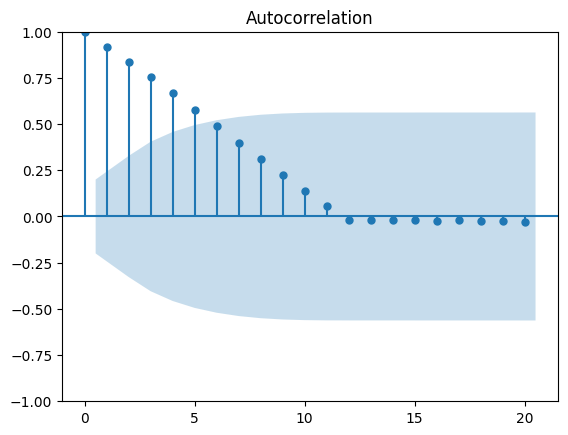

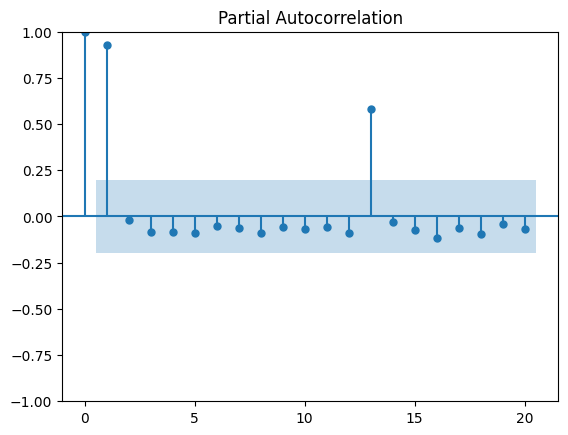

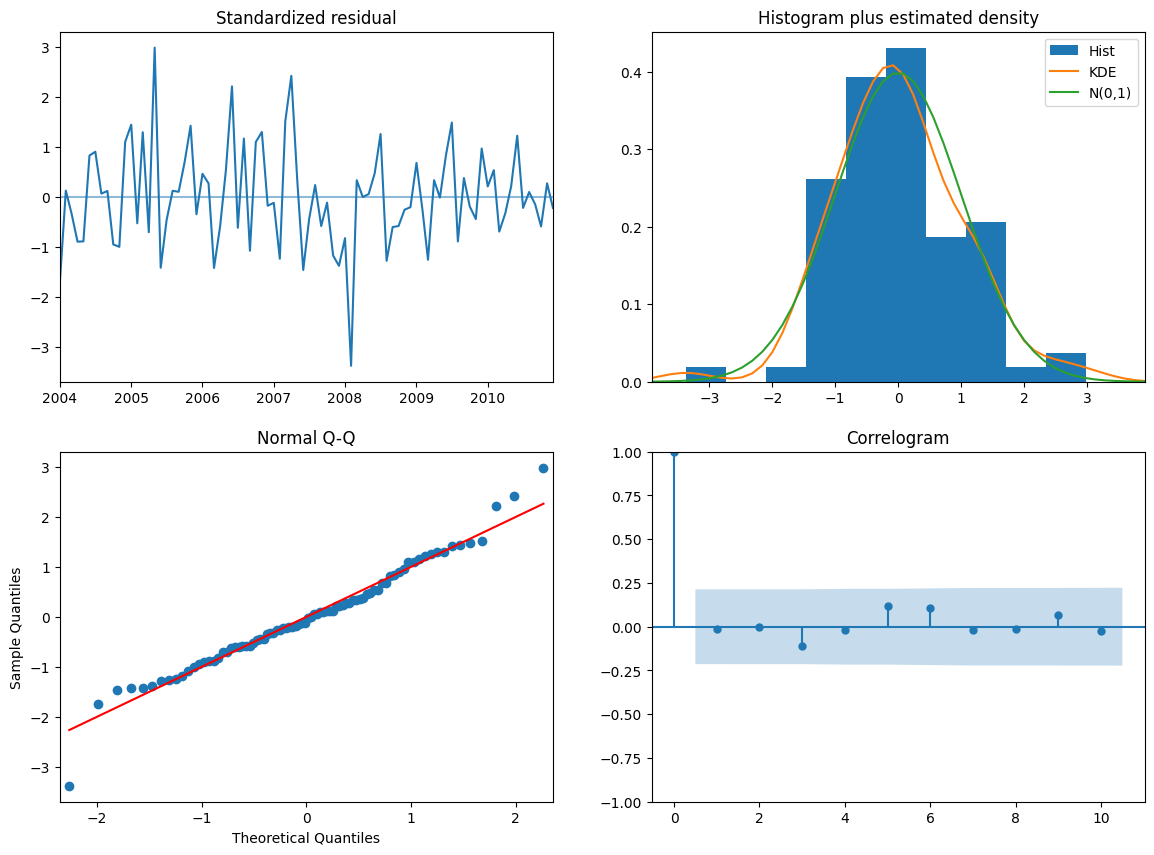

In [141]:

train = Log_Datos.loc[:"2010-12-01 00:00:00"]
test = Log_Datos["2011-01-01 00:00:00":]
# Pasamos a utilizar el AutoArima  (No lo hace bien)
ArimaModel = pmdarima.auto_arima(train, error_action='ignore', seasonal=True, m=12,start_p=1,start_d=1,start_q=1,max_D=1)

ArimaModel.summary()

# Sacamos las predicciones del modelo.
test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))


# Estas predicciones son logaritmos por lo que hay que invertir el proceso
test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
test["Predicciones"]  = np.exp(test["Predicciones"])

# Graficamos los datos de test.
plt.plot(test)


# Analizamos los residuos del modelo.
plt.plot(ArimaModel.resid())

# Comprobamos que los residuos iniciales son altos

# Analizamos el correlograma y el correlograma parcial de los errores
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ArimaModel.resid())
plot_pacf(ArimaModel.resid())

ArimaModel.plot_diagnostics(figsize = (14,10));


In [142]:
ArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 153.002
Date:                            Fri, 03 Feb 2023   AIC                           -294.003
Time:                                    18:59:59   BIC                           -279.419
Sample:                                01-01-2003   HQIC                          -288.140
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0561      0.029      1.959      0.050   -2.04e-05       0.112
ar.L1          0.5536      0.116      4.778      0.000       0.327       0.781
ar.L2          0.2133      0.112      1.911      0.056      -0.005       0.432
ar.S.L12      -0.5638      0.134     -4.195      0.000      -0.827      -0.300
ar.S.L24      -0.2363      0.158     -1.494      0.135      -0.546       0.074
sigma2         0.0014      0.000      6.173      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.91   Prob(JB):                         0.10
Heteroskedasticity (H):               0.36   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""